# 🚢 Titanic Survival Analysis

### ⚙️ Importing Libraries & Environment Setup

In [ ]:
from collections.abc import Callable
from pathlib import Path
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import xgboost as xgb
from colorama import Fore, Style
from numpy.typing import NDArray
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    explained_variance_score,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    precision_score,
    r2_score,
    recall_score,
    roc_auc_score,
    root_mean_squared_error,
)
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [291]:
%matplotlib inline

pd.set_option("display.width", 175)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)

In [ ]:
should_save_submission = True

# Determine dataset directory based on environment
if Path("/kaggle/input/titanic").exists():
    dataset_path = "/kaggle/input/titanic"  # Kaggle
    should_save_submission = True
elif Path("./dataset").exists():
    dataset_path = "./dataset"  # Local
else:
    raise FileNotFoundError("Dataset directory not found.")

## 🛠️ Utility Functions

In [293]:
def evaluate_regression_models(
    predictions: dict[str, NDArray[np.float64]], y: NDArray[np.float64]
) -> pd.DataFrame:
    """Evaluate multiple regression model predictions on the given dataset.

    Args:
        predictions (dict[str, NDArray[np.float64]]): Dictionary where keys are
            model names and values are predicted target arrays corresponding to X.
        y (NDArray[np.float64]): True target values of shape (n_samples,).

    Returns:
        pd.DataFrame: DataFrame with evaluation metrics (MAE, MSE, RMSE, R², EVS) for
            each model. Columns correspond to model names; rows correspond to metrics.
    """
    evaluations = pd.DataFrame(
        columns=predictions.keys(), index=["MAE", "MSE", "RMSE", "R²", "EVS"]
    )

    for name, y_pred in predictions.items():
        metrics = {
            "MAE": mean_absolute_error(y, y_pred),
            "MSE": mean_squared_error(y, y_pred),
            "RMSE": root_mean_squared_error(y, y_pred),
            "R²": r2_score(y, y_pred),
            "EVS": explained_variance_score(y, y_pred),
        }

        evaluations.loc[:, name] = metrics

    return evaluations.astype(float)

In [294]:
def evaluate_classification(
    y_pred: NDArray[np.float64], y_true: NDArray[np.float64]
) -> pd.DataFrame:
    """Evaluate multiple classification model predictions on the provided dataset.

    Args:
        y_pred (NDArray[np.float64]): Predicted probabilities or binary outputs.
        y_true (NDArray[np.float64]): True binary target values of shape (n_samples,).

    Returns:
        pd.DataFrame: DataFrame containing classification metrics — Accuracy, Precision,
            Recall, F1-score, and ROC AUC. Rows correspond to the metric names.
    """
    # If predictions are probabilities, binarize with threshold 0.5
    y_pred_bin = (y_pred > 0.5).astype(int)

    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred_bin),
        "Precision": precision_score(y_true, y_pred_bin),
        "Recall": recall_score(y_true, y_pred_bin),
        "F1-score": f1_score(y_true, y_pred_bin),
        "ROC AUC": roc_auc_score(y_true, y_pred),
    }

    return pd.DataFrame.from_dict(metrics, orient="index", columns=["score"]).T

In [295]:
def plot_confusion_matrix(y_true: NDArray[np.int64], y_pred: NDArray[np.int64]) -> None:
    """Display a confusion matrix using seaborn heatmap.

    Args:
        y_true (NDArray[np.int64]): True labels.
        y_pred (NDArray[np.int64]): Predicted labels.
    """
    conf_matrix = confusion_matrix(y_true, y_pred)

    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
    )
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

In [332]:
def plot_feature_importance(importance_df: pd.DataFrame) -> None:
    """Display feature importance barplot using seaborn.

    Args:
        importance_df (pd.DataFrame): DataFrame с двумя столбцами:
            'feature' — названия признаков,
            'importance' — значения важности.
    """
    importance_df = importance_df.sort_values(by="importance", ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=importance_df,
        x="importance",
        y="feature",
        hue="feature",
        palette="viridis",
    )
    plt.title("Feature Importance (Gain)")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

In [297]:
class PandasProxy:
    """A proxy class that provides controlled access to a pandas DataFrame."""

    def __init__(
        self, get_df: Callable[[], pd.DataFrame], set_df: Callable[[pd.DataFrame], None]
    ) -> None:
        """Initialize the proxy with getter and setter functions.

        Args:
            get_df (Callable[[], pd.DataFrame]): Function to retrieve the DataFrame.
            set_df (Callable[[pd.DataFrame], None]): Function to set/update the
                DataFrame.
        """
        self._get_df = get_df
        self._set_df = set_df

    def __getitem__(self, key: Any) -> Any:
        """Retrieve an item from the proxied DataFrame."""
        return self._get_df()[key]

    def __setitem__(self, key: Any, value: Any) -> None:
        """Set a value in the proxied DataFrame and update it."""
        df = self._get_df()
        df[key] = value
        self._set_df(df)

    def __getattr__(self, name: str) -> Any:
        """Forward attribute access to the proxied DataFrame."""
        return getattr(self._get_df(), name)


class DatasetManager:
    """Manages training and testing datasets.

    This class maintains synchronization between the separate train/test DataFrames and
    their concatenated form. Updating the combined DataFrame automatically updates
    the individual train and test DataFrames.
    """

    def __init__(self, train_df: pd.DataFrame, test_df: pd.DataFrame) -> None:
        """Initialize DatasetManager with train and test DataFrames.

        Args:
            train_df (pd.DataFrame): Training data.
            test_df (pd.DataFrame): Testing data.
        """
        self._train_df = train_df.reset_index(drop=True)
        self._test_df = test_df.reset_index(drop=True)

        self._train_size = len(self._train_df)
        self._columns_to_drop_from_test = list(
            set(self._train_df.columns) - set(self._test_df.columns)
        )
        self._combined_df = pd.concat([self._train_df, self._test_df]).reset_index(
            drop=True
        )

        self._combined_df_proxy = PandasProxy(
            self._get_combined_df, self._set_combined_df
        )

        self._assign_names()

    def _assign_names(self) -> None:
        """Assign descriptive names to train, test, and combined DataFrames."""
        self._train_df.name = "Training Set"
        self._test_df.name = "Test Set"
        self._combined_df.name = "Combined Set"

    def _get_combined_df(self) -> pd.DataFrame:
        """Get the combined DataFrame of train and test datasets.

        Returns:
            pd.DataFrame: Concatenated DataFrame of train and test sets.
        """
        return self._combined_df

    def _set_combined_df(self, new_combined_df: pd.DataFrame) -> None:
        """Set the combined DataFrame and update the train and test DataFrames.

        Args:
            new_combined_df (pd.DataFrame): New combined DataFrame.
        """
        self._combined_df = new_combined_df
        self._train_df = self._combined_df.iloc[: self._train_size].reset_index(
            drop=True
        )
        self._test_df = (
            self._combined_df.iloc[self._train_size :]
            .drop(self._columns_to_drop_from_test, axis=1)
            .reset_index(drop=True)
        )
        self._assign_names()

    @property
    def combined_df(self) -> PandasProxy:
        """Get a proxy to the combined DataFrame of train and test datasets.

        Returns:
            PandasProxy: Proxy object allowing controlled access to the DataFrame.
        """
        return self._combined_df_proxy

    @combined_df.setter
    def combined_df(self, new_combined_df: pd.DataFrame) -> None:
        """Set the combined DataFrame and update the train and test DataFrames.

        Args:
            new_combined_df (pd.DataFrame): New combined DataFrame.
        """
        self._set_combined_df(new_combined_df)

    @property
    def train_df(self) -> pd.DataFrame:
        """Get the training DataFrame.

        Returns:
            pd.DataFrame: Training dataset.
        """
        return self._train_df

    @property
    def test_df(self) -> pd.DataFrame:
        """Get the testing DataFrame.

        Returns:
            pd.DataFrame: Testing dataset.
        """
        return self._test_df

    @property
    def train_test_dfs(self) -> tuple[pd.DataFrame, pd.DataFrame]:
        """Get the separate train and test DataFrames.

        Returns:
            tuple[pd.DataFrame, pd.DataFrame]: Tuple containing (train_df, test_df).
        """
        return self._train_df, self._test_df

## 📥 Load and Inspect Dataset

In [298]:
train_df = pd.read_csv(f"{dataset_path}/train.csv")
test_df = pd.read_csv(f"{dataset_path}/test.csv")
dm = DatasetManager(train_df, test_df)

In [299]:
print(f"{Fore.MAGENTA}DataFrame Info:{Style.RESET_ALL}")
for df in dm.train_test_dfs:
    print(f"\n{Fore.CYAN}====== {df.name} ======{Style.RESET_ALL}")
    df.info()

DataFrame Info:

====== Training Set ======
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

====== Test Set ======
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       -----------

In [300]:
print(f"{Fore.GREEN}DataFrame Description:{Style.RESET_ALL}")
for df in dm.train_test_dfs:
    print(f"\n{Fore.CYAN}====== {df.name} ======{Style.RESET_ALL}")
    print(df.describe(include="all"))

DataFrame Description:

====== Training Set ======
        PassengerId    Survived      Pclass                     Name   Sex         Age       SibSp       Parch  Ticket        Fare Cabin Embarked
count    891.000000  891.000000  891.000000                      891   891  714.000000  891.000000  891.000000     891  891.000000   204      889
unique          NaN         NaN         NaN                      891     2         NaN         NaN         NaN     681         NaN   147        3
top             NaN         NaN         NaN  Braund, Mr. Owen Harris  male         NaN         NaN         NaN  347082         NaN    G6        S
freq            NaN         NaN         NaN                        1   577         NaN         NaN         NaN       7         NaN     4      644
mean     446.000000    0.383838    2.308642                      NaN   NaN   29.699118    0.523008    0.381594     NaN   32.204208   NaN      NaN
std      257.353842    0.486592    0.836071                      NaN   Na

In [301]:
print(f"{Fore.YELLOW}First Rows of DataFrame:{Style.RESET_ALL}")
for df in dm.train_test_dfs:
    print(f"\n{Fore.CYAN}====== {df.name} ======{Style.RESET_ALL}")
    print(df.head())

First Rows of DataFrame:

====== Training Set ======
   PassengerId  Survived  Pclass                                               Name     Sex   Age  SibSp  Parch            Ticket     Fare Cabin Embarked
0            1         0       3                            Braund, Mr. Owen Harris    male  22.0      1      0         A/5 21171   7.2500   NaN        S
1            2         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1      0          PC 17599  71.2833   C85        C
2            3         1       3                             Heikkinen, Miss. Laina  female  26.0      0      0  STON/O2. 3101282   7.9250   NaN        S
3            4         1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1      0            113803  53.1000  C123        S
4            5         0       3                           Allen, Mr. William Henry    male  35.0      0      0            373450   8.0500   NaN        S

====== Test Set ======

In [302]:
print(f"{Fore.RED}Missing Values in Each Column:{Style.RESET_ALL}")
for df in dm.train_test_dfs:
    print(f"\n{Fore.CYAN}====== {df.name} ======{Style.RESET_ALL}")
    print(df.isnull().sum())

Missing Values in Each Column:

====== Training Set ======
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

====== Test Set ======
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


## 🧹 Feature Engineering

#### 🏷️ Fare Binning

In [303]:
median_fare = dm.combined_df.groupby(["Pclass", "Parch", "SibSp"])["Fare"].median()[3][
    0
][0]

dm.combined_df.fillna({"Embarked": "S", "Fare": median_fare}, inplace=True)
dm.combined_df["Fare"] = pd.qcut(dm.combined_df["Fare"], 13)

#### 🧑‍🎓 Title Extraction from Name

In [304]:
dm.combined_df["Title"] = dm.combined_df["Name"].str.extract(
    r",\s*([^\.]*)\s*\.", expand=False
)
dm.combined_df["Title"] = dm.combined_df["Title"].replace(
    ["Miss", "Mrs", "Ms", "Mlle", "Lady", "Mme", "the Countess", "Dona"],
    "Miss/Mrs/Ms",
)
dm.combined_df["Title"] = dm.combined_df["Title"].replace(
    ["Dr", "Col", "Major", "Jonkheer", "Capt", "Sir", "Don", "Rev"],
    "Dr/Military/Noble/Clergy",
)

#### 👪 Family&Ticket-Based Features

In [305]:
dm.combined_df["FamilyLastName"] = dm.combined_df["Name"].str.split(",").str[0]
dm.combined_df["FamilySize"] = dm.combined_df["SibSp"] + dm.combined_df["Parch"] + 1
dm.combined_df["FamilySizeGrouped"] = (
    dm.combined_df["FamilySize"]
    .replace([1], "Alone")
    .replace([2, 3, 4], "Small")
    .replace([5, 6], "Medium")
    .replace([7, 8, 9, 10, 11], "Large")
)

ticket_counts = dm.combined_df["Ticket"].value_counts()
dm.combined_df["TicketCount"] = dm.combined_df["Ticket"].map(ticket_counts).fillna(1)

dm.combined_df["WithFamily"] = (dm.combined_df["FamilySize"] > 1).astype(int)
dm.combined_df["WithFriends"] = (
    (dm.combined_df["FamilySize"] == 1) & (dm.combined_df["TicketCount"] > 1)
).astype(int)
dm.combined_df["TrulyAlone"] = (
    (dm.combined_df["FamilySize"] == 1) & (dm.combined_df["TicketCount"] == 1)
).astype(int)

#### 🛏️ Cabin Deck Extraction

In [306]:
dm.combined_df["Deck"] = dm.combined_df["Cabin"].apply(
    lambda s: s[0] if pd.notnull(s) else "M"
)
idx = dm.combined_df[dm.combined_df["Deck"] == "T"].index
dm.combined_df.loc[idx, "Deck"] = "A"

dm.combined_df["Deck"] = dm.combined_df["Deck"].replace(["A", "B", "C"], "ABC")
dm.combined_df["Deck"] = dm.combined_df["Deck"].replace(["D", "E"], "DE")
dm.combined_df["Deck"] = dm.combined_df["Deck"].replace(["F", "G"], "FG")

#### 🔤 Encoding Categorical Features

In [307]:
non_numeric_features = [
    "Sex",
    "Deck",
    "Title",
    "Embarked",
    "Fare",
    "FamilyLastName",
    "FamilySizeGrouped",
]
le = LabelEncoder()

for feature in non_numeric_features:
    dm.combined_df[feature] = le.fit_transform(dm.combined_df[feature])

#### 👶 Age Imputation with Model

In [308]:
age_features = [
    "Pclass",
    "Sex",
    "SibSp",
    "Parch",
    "Fare",
    "Embarked",
    "Title",
    "FamilySize",
    "TicketCount",
    "Deck",
    "FamilyLastName",
    "FamilySizeGrouped",
    "WithFamily",
    "WithFriends",
    "TrulyAlone",
]

known_age = dm.combined_df[dm.combined_df["Age"].notnull()]
missing_age = dm.combined_df[dm.combined_df["Age"].isnull()]

X_age, y_age = known_age[age_features], known_age["Age"]

X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(
    X_age, y_age, test_size=0.2, random_state=42
)

In [309]:
class AgeObjective:
    """Objective function class for Optuna hyperparameter optimization.

    This class wraps training and evaluation logic to be used in Optuna's optimization
    loop. It supports randomized cross-validation and logs the cross-validated accuracy
    for each trial.
    """

    def __init__(
        self,
        X: NDArray[np.float64],
        y: NDArray[np.float64],
        random_state: int | None = None,
    ) -> None:
        """Initializes the Objective class.

        Args:
            X (NDArray[np.float64]): Feature matrix.
            y (NDArray[np.float64]): Target vector.
            random_state (int | None): Random seed for reproducibility. Default is None.
        """
        self.X = X
        self.y = y
        self.random_state = random_state

    def __call__(self, trial: optuna.trial.Trial) -> float:
        """Objective function for Optuna study to optimize hyperparameters.

        Parameters:
            trial (Trial): A single trial object that suggests hyperparameter values.

        Returns:
            float: Cross-validated accuracy score (mean of folds).
        """
        model_name = trial.suggest_categorical("model", ["rf", "knn"])

        if model_name == "rf":
            params = {
                "n_estimators": trial.suggest_int("n_estimators", 10, 300),
                "max_depth": trial.suggest_int("max_depth", 3, 12),
                "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
                "random_state": self.random_state,
            }

            model = RandomForestRegressor(**params)
        elif model_name == "knn":
            params = {
                "n_neighbors": trial.suggest_int("n_neighbors", 1, 30),
                "weights": trial.suggest_categorical(
                    "weights", ["uniform", "distance"]
                ),
                "p": trial.suggest_categorical("p", [1, 2]),
            }

            model = Pipeline(
                [("scaler", StandardScaler()), ("model", KNeighborsRegressor(**params))]
            )
        else:
            raise ValueError("")

        cv = KFold(n_splits=5, shuffle=True, random_state=self.random_state)
        scores = cross_val_score(
            model, self.X, self.y, cv=cv, scoring="neg_mean_squared_error"
        )

        score = -np.mean(scores)
        trial.set_user_attr("cv_score", score)
        return score


age_study = optuna.create_study(
    direction="minimize",
    study_name="age",
    sampler=optuna.samplers.TPESampler(seed=42),
)

age_objective = AgeObjective(X_train_age, y_train_age, random_state=42)
age_study.optimize(age_objective, n_trials=50)

[I 2025-08-01 19:48:07,592] A new study created in memory with name: age
[I 2025-08-01 19:48:07,677] Trial 0 finished with value: 151.10569635912208 and parameters: {'model': 'knn', 'n_neighbors': 22, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 151.10569635912208.
[I 2025-08-01 19:48:08,963] Trial 1 finished with value: 149.4764926119446 and parameters: {'model': 'rf', 'n_estimators': 216, 'max_depth': 3, 'min_samples_split': 10}. Best is trial 1 with value: 149.4764926119446.
[I 2025-08-01 19:48:09,405] Trial 2 finished with value: 142.07157290652395 and parameters: {'model': 'rf', 'n_estimators': 62, 'max_depth': 4, 'min_samples_split': 4}. Best is trial 2 with value: 142.07157290652395.
[I 2025-08-01 19:48:10,456] Trial 3 finished with value: 144.52228791851078 and parameters: {'model': 'rf', 'n_estimators': 94, 'max_depth': 9, 'min_samples_split': 3}. Best is trial 2 with value: 142.07157290652395.
[I 2025-08-01 19:48:10,516] Trial 4 finished with value: 154.53832869

In [310]:
print(
    f"{Fore.GREEN}Best hyperparameters found:{Style.RESET_ALL}", age_study.best_params
)
print(f"{Fore.YELLOW}Best CV score:{Style.RESET_ALL}", age_study.best_value)

Best hyperparameters found: {'model': 'rf', 'n_estimators': 163, 'max_depth': 6, 'min_samples_split': 6}
Best CV score: 137.83147040235323


In [311]:
age_baseline = DummyRegressor(strategy="median")
age_baseline.fit(X_train_age, y_train_age)

age_best_params = age_study.best_params
age_best_model = age_best_params.pop("model")
if age_best_model == "rf":
    best_age_model = RandomForestRegressor(**age_best_params, random_state=42)
elif age_best_model == "knn":
    best_age_model = Pipeline(
        [
            ("scaler", StandardScaler()),
            ("model", KNeighborsRegressor(**age_best_params)),
        ]
    )
else:
    raise ValueError("")

best_age_model.fit(X_train_age, y_train_age)

age_predictions = {
    "median": age_baseline.predict(X_test_age),
    "optuna": best_age_model.predict(X_test_age),
}

evaluate_regression_models(age_predictions, y_test_age)

,median,optuna
MAE,10.007952,7.963538
MSE,167.020471,103.735853
RMSE,12.923640,10.185080
R²,-0.005118,0.375724
EVS,0.000000,0.386005


In [312]:
dm.combined_df.loc[dm.combined_df["Age"].isnull(), "Age"] = best_age_model.predict(
    missing_age[age_features]
)
dm.combined_df["Age"] = pd.qcut(dm.combined_df["Age"], 10)
dm.combined_df["Age"] = le.fit_transform(dm.combined_df["Age"])

---

In [313]:
dm.combined_df = dm.combined_df.drop(columns=["Name", "Ticket", "Cabin"])

In [314]:
print(f"{Fore.RED}Missing Values in Each Column:{Style.RESET_ALL}")
for df in dm.train_test_dfs:
    print(f"\n{Fore.CYAN}====== {df.name} ======{Style.RESET_ALL}")
    print(df.isnull().sum())

Missing Values in Each Column:

====== Training Set ======
PassengerId          0
Survived             0
Pclass               0
Sex                  0
Age                  0
SibSp                0
Parch                0
Fare                 0
Embarked             0
Title                0
FamilyLastName       0
FamilySize           0
FamilySizeGrouped    0
TicketCount          0
WithFamily           0
WithFriends          0
TrulyAlone           0
Deck                 0
dtype: int64

====== Test Set ======
PassengerId          0
Pclass               0
Sex                  0
Age                  0
SibSp                0
Parch                0
Fare                 0
Embarked             0
Title                0
FamilyLastName       0
FamilySize           0
FamilySizeGrouped    0
TicketCount          0
WithFamily           0
WithFriends          0
TrulyAlone           0
Deck                 0
dtype: int64


## 📊 Exploratory Data Visualizations

#### 🚢 General Survival Analysis

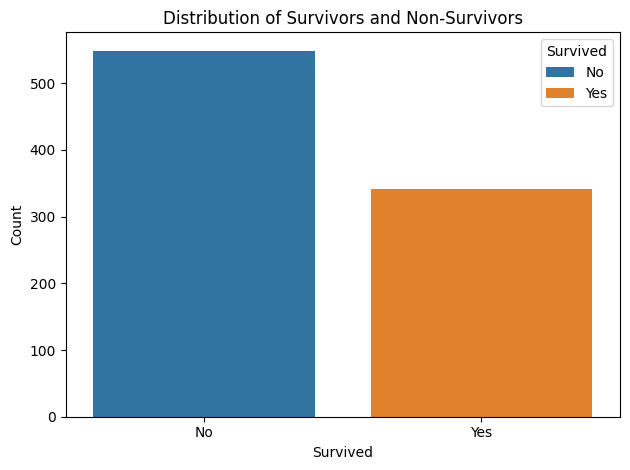

In [315]:
sns.countplot(x="Survived", data=dm.train_df, hue="Survived")
plt.title("Distribution of Survivors and Non-Survivors")
plt.xlabel("Survived")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=["No", "Yes"])
plt.legend(title="Survived", labels=["No", "Yes"])
plt.tight_layout()
plt.show()

#### 🔗 Feature Correlation Matrix

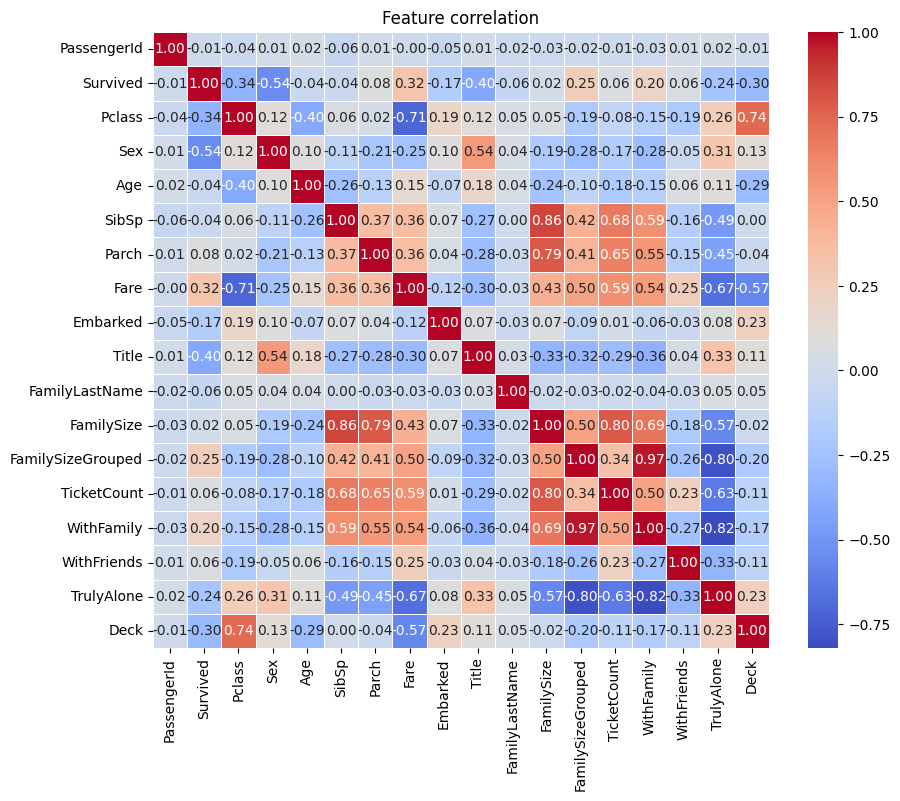

In [316]:
corr = dm.combined_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Feature correlation")
plt.show()

#### 💰 Wealth & Port of Embarkation vs Survival

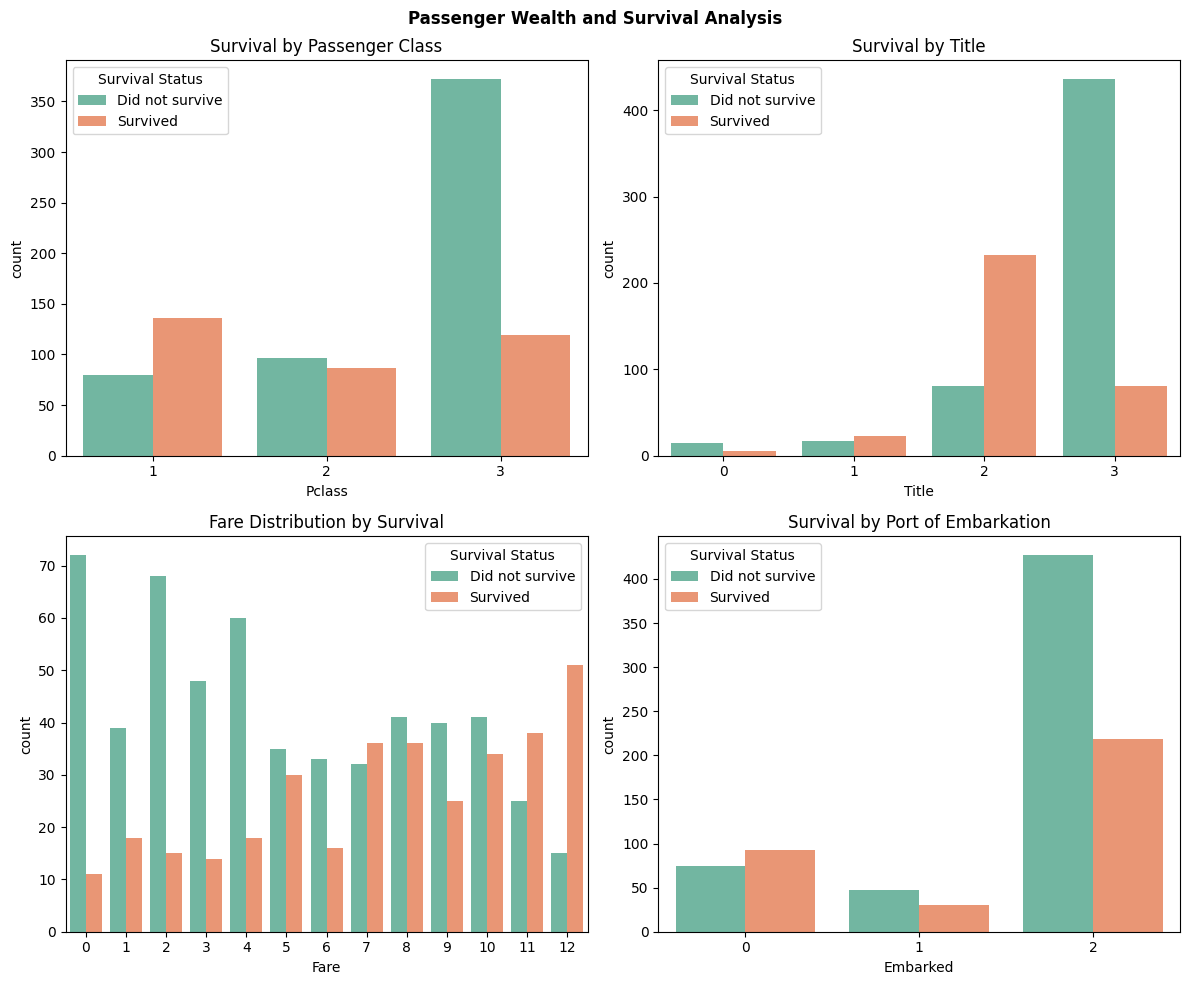

In [317]:
palette = "Set2"

fig = plt.figure(figsize=(12, 10))
fig.suptitle("Passenger Wealth and Survival Analysis", fontweight="bold")

ax1 = plt.subplot2grid((2, 2), (0, 0))
sns.countplot(x="Pclass", hue="Survived", data=dm.train_df, ax=ax1, palette=palette)
ax1.set_title("Survival by Passenger Class")
ax1.legend(title="Survival Status", labels=["Did not survive", "Survived"])

ax2 = plt.subplot2grid((2, 2), (0, 1))
sns.countplot(x="Title", hue="Survived", data=dm.train_df, ax=ax2, palette=palette)
ax2.set_title("Survival by Title")
ax2.legend(title="Survival Status", labels=["Did not survive", "Survived"])

ax3 = plt.subplot2grid((2, 2), (1, 0))
sns.countplot(x="Fare", hue="Survived", data=dm.train_df, ax=ax3, palette=palette)
ax3.set_title("Fare Distribution by Survival")
ax3.legend(title="Survival Status", labels=["Did not survive", "Survived"])

ax4 = plt.subplot2grid((2, 2), (1, 1))
sns.countplot(x="Embarked", hue="Survived", data=dm.train_df, ax=ax4, palette=palette)
ax4.set_title("Survival by Port of Embarkation")
ax4.legend(title="Survival Status", labels=["Did not survive", "Survived"])

plt.tight_layout()
plt.show()

#### 🧬 Demographics and Relationships

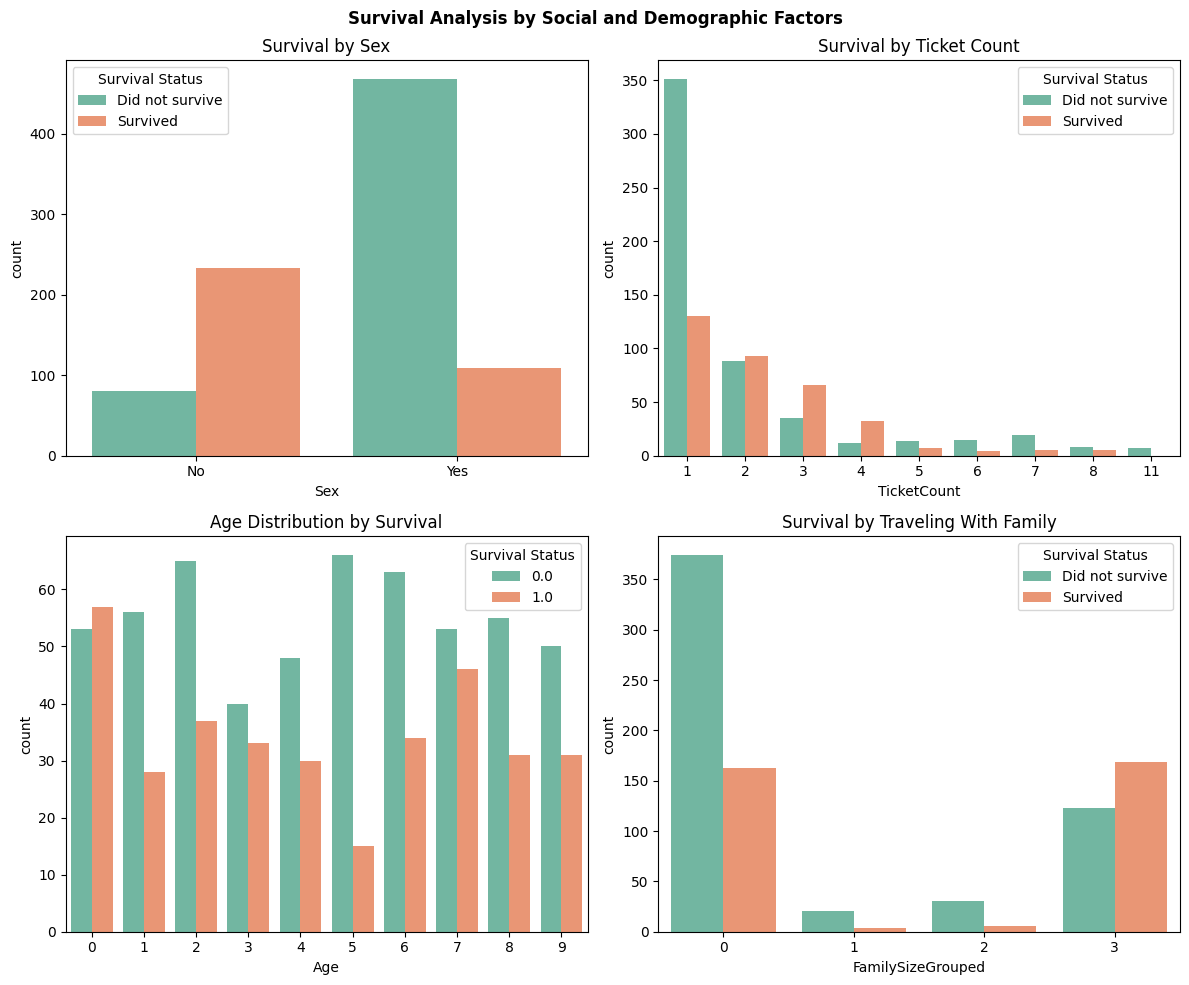

In [318]:
palette = "Set2"

fig = plt.figure(figsize=(12, 10))
fig.suptitle("Survival Analysis by Social and Demographic Factors", fontweight="bold")

ax1 = plt.subplot2grid((2, 2), (0, 0))
sns.countplot(x="Sex", hue="Survived", data=dm.train_df, ax=ax1, palette=palette)
ax1.set_title("Survival by Sex")
ax1.set_xticks([0, 1])
ax1.set_xticklabels(["No", "Yes"])
ax1.legend(title="Survival Status", labels=["Did not survive", "Survived"])

ax2 = plt.subplot2grid((2, 2), (0, 1))
sns.countplot(
    x="TicketCount", hue="Survived", data=dm.train_df, ax=ax2, palette=palette
)
ax2.set_title("Survival by Ticket Count")
ax2.legend(title="Survival Status", labels=["Did not survive", "Survived"])

ax3 = plt.subplot2grid((2, 2), (1, 0))
sns.countplot(x="Age", hue="Survived", data=dm.train_df, ax=ax3, palette=palette)
ax3.set_title("Age Distribution by Survival")
ax3.legend(title="Survival Status")

ax4 = plt.subplot2grid((2, 2), (1, 1))
sns.countplot(
    x="FamilySizeGrouped", hue="Survived", data=dm.train_df, ax=ax4, palette=palette
)
ax4.set_title("Survival by Traveling With Family")
ax4.legend(title="Survival Status", labels=["Did not survive", "Survived"])

plt.tight_layout()
plt.show()

## 🧪 Model Training

In [319]:
features = [
    "Pclass",
    "Sex",
    "Age",
    "Embarked",
    "Title",
    "Deck",
    "Fare",
    "TicketCount",
    "FamilyLastName",
    "FamilySize",
    "FamilySizeGrouped",
    "WithFamily",
    "WithFriends",
    "TrulyAlone",
]

X, y = dm.train_df[features], dm.train_df["Survived"]

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
class Objective:
    """Objective function class for Optuna hyperparameter optimization.

    This class wraps training and evaluation logic to be used in Optuna's optimization
    loop. It supports randomized cross-validation and logs the cross-validated accuracy
    for each trial.
    """

    def __init__(
        self,
        X: NDArray[np.float64],
        y: NDArray[np.float64],
        random_state: int | None = None,
    ) -> None:
        """Initializes the Objective class.

        Args:
            X (NDArray[np.float64]): Feature matrix.
            y (NDArray[np.float64]): Target vector.
            random_state (int | None): Random seed for reproducibility. Default is None.
        """
        self.X = X
        self.y = y
        self.random_state = random_state

    def __call__(self, trial: optuna.trial.Trial) -> float:
        """Objective function for Optuna study to optimize hyperparameters.

        Parameters:
            trial (Trial): A single trial object that suggests hyperparameter values.

        Returns:
            float: Cross-validated accuracy score (mean of folds).
        """
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 10, 300),
            "max_depth": trial.suggest_int("max_depth", 3, 12),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "eval_metric": "logloss",
            "random_state": self.random_state,
        }

        model = xgb.XGBClassifier(**params)

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=self.random_state)
        scores = cross_val_score(model, self.X, self.y, cv=cv, scoring="accuracy")

        score = np.median(scores)
        trial.set_user_attr("cv_accuracy", score)
        return score


study = optuna.create_study(
    direction="maximize",
    study_name="xgb",
    sampler=optuna.samplers.TPESampler(seed=42),
)

objective = Objective(X_train, y_train, random_state=42)
study.optimize(objective, n_trials=100)

[I 2025-08-01 19:49:18,167] A new study created in memory with name: xgb
[I 2025-08-01 19:49:18,826] Trial 0 finished with value: 0.8098591549295775 and parameters: {'n_estimators': 118, 'max_depth': 12, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 0.8098591549295775.
[I 2025-08-01 19:49:18,987] Trial 1 finished with value: 0.8309859154929577 and parameters: {'n_estimators': 55, 'max_depth': 3, 'learning_rate': 0.19030368381735815, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 1 with value: 0.8309859154929577.
[I 2025-08-01 19:49:19,104] Trial 2 finished with value: 0.823943661971831 and parameters: {'n_estimators': 15, 'max_depth': 12, 'learning_rate': 0.16967533607196555, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 1 with value: 0.8309859154929577.
[I 2025-08-01 19:49:19,356] Trial 3 finished with value: 0.

### 📊 Model Evaluation

In [321]:
model = xgb.XGBClassifier(**study.best_params, eval_metric="logloss", random_state=42)
model.fit(X_train, y_train)

y_proba = model.predict_proba(X_valid)[:, 1]
y_pred = y_proba > 0.5

In [322]:
print(f"{Fore.GREEN}Best hyperparameters found:{Style.RESET_ALL}", study.best_params)
print(f"{Fore.YELLOW}Best CV score:{Style.RESET_ALL}", study.best_value)

Best hyperparameters found: {'n_estimators': 206, 'max_depth': 6, 'learning_rate': 0.020620817276479204, 'subsample': 0.8578309891148542, 'colsample_bytree': 0.9140606511470843}
Best CV score: 0.852112676056338


In [323]:
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()
optuna.visualization.plot_parallel_coordinate(study).show()

In [324]:
evaluate_classification(y_proba, y_valid)

,Accuracy,Precision,Recall,F1-score,ROC AUC
score,0.860335,0.865672,0.783784,0.822695,0.907722


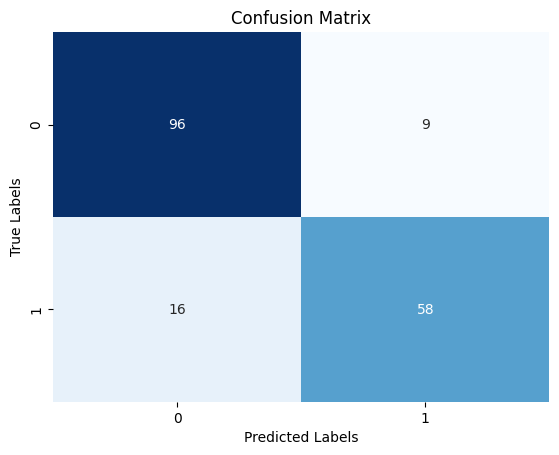

In [325]:
plot_confusion_matrix(y_valid, y_pred)

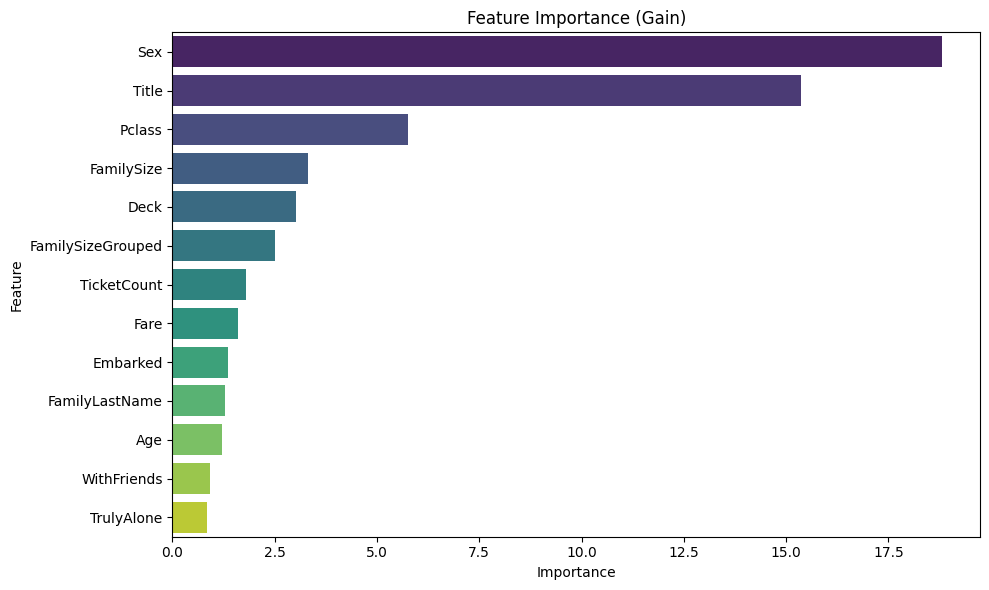

In [333]:
importance_dict = model.get_booster().get_score(importance_type="gain")

importance_df = pd.DataFrame(
    {
        "feature": list(importance_dict.keys()),
        "importance": list(importance_dict.values()),
    }
)

plot_feature_importance(importance_df)

### 🧠 Final Model Training

In [ ]:
final_model = xgb.XGBClassifier(
    **study.best_params, eval_metric="logloss", random_state=42
)
final_model.fit(X, y)

submission_predictions = final_model.predict(dm.test_df[features])

if should_save_submission:
    submission_df = pd.DataFrame(
        {"PassengerId": dm.test_df["PassengerId"], "Survived": submission_predictions}
    )
    submission_df.to_csv("submission.csv", index=False)
    print(f"{Fore.GREEN}Submission was successfully saved!{Style.RESET_ALL}")
else:
    print(f"{Fore.YELLOW}Submission not saved.{Style.RESET_ALL}")

Submission was successfully saved!
